In [1]:
import numpy as np
import h5py
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import time
from random import shuffle
from itertools import product
import multiprocessing as mp
from math import fabs, sqrt, log, exp

In [2]:
def bound(loss, L, lam):
    '''
    Calculate annoying parameters to estimate rho
    '''

    R1 = 0.0
    R2 = 0.0
    Sp1 = 0.0
    Sm1 = 0.0
    Sp2 = 0.0
    Sm2 = 0.0
    for i in range(N + 1):
        # compute plus
        alpha0 = L ** i
        alpha1 = i * L ** (i - 1)
        alpha2 = i * (i - 1) * L ** (i - 2)
        R1 += alpha0
        Sp1 += alpha1
        Sp2 += alpha2
        # compute minus
        beta0 = 0.0
        beta1 = 0.0
        beta2 = 0.0
        for k in range(i, N + 1):
            # compute forward difference
            delta = 0.0
            for j in range(k + 1):
                delta += comb_dict[k][j] * (-1) ** (k - j) * loss(j / N)
            # compute coefficient
            beta0 += comb_dict[N][k] * comb_dict[k][i] * (N + 1) * fabs(delta) / (2 ** k) / (L ** i)
            beta1 += comb_dict[N][k] * comb_dict[k][i] * (N + 1) * (k - i) * fabs(delta) / (2 ** k) / (L ** (i + 1))
            beta2 += comb_dict[N][k] * comb_dict[k][i] * (N + 1) * (k - i) * (k - i - 1) * fabs(delta) / (2 ** k) / (
                        L ** (i + 2))
        R2 += beta0
        Sm1 += beta1
        Sm2 += beta2

    rho = max((2 * R1 + R2) * Sp2, (2 * R2 + R1) * Sm2)/ (N + 1)
    gamma0_v1 = max(0, rho - lam + 1 / (N + 1))
    gamma0_v2 = max((2 * R1 + R2) * Sp2 + Sp1 ** 2, (2 * R2 + R1) * Sm2 + Sm1 ** 2) / (N + 1)
    print('R1: %.2f R2: %.2f rho: %.2f old gamma: %.2f new gamma: %.2f' %(R1,R2,rho,gamma0_v1,gamma0_v2))

    return R1, R2, rho, gamma0_v1, gamma0_v2

In [3]:
def loss_func(loss, L):
    # define loss function
    if loss == 'hinge':
        lo = lambda x: max(0, 1 + L - 2 * L * x)
    elif loss == 'logistic':
        lo = lambda x: log(1 + exp(L - 2 * L * x))
    else:
        print('Wrong loss function!')

    return lo

In [5]:
def right_func(L,lam):
    return lam/2*(L/2)**2

In [6]:
def left_func(loss,L):
    
    if loss == 'hinge':
        l = lambda x: max(0,1+L-2*L*x)
    elif loss == 'logistic':
        l = lambda x:log(1+exp(L-2*L*x))
    else:
        print('Wrong loss function!')
    
    B0 = 0.0
    for k in range(N+1):
        B0 += comb_dict[N][k]*l(k/N)
        
    return B0/2**N

In [7]:
def dichotomy(loss,lam,a,b,tol,max_iter):
    fa = right_func(a,lam) - left_func(loss,a)
    fb = right_func(b,lam) - left_func(loss,b)
    if fa*fb > 0:
        print('Wrong search!')
        return
    i = 1
    while i<max_iter:
        fa = right_func(a,lam) - left_func(loss,a)
        fb = right_func(b,lam) - left_func(loss,b)
        c = (a+b)/2
        fc = right_func(c,lam) - left_func(loss,c)
        if fc == 0 or (b - a)/2 < tol:
            print('Found!')
            return c
        i += 1
        if fa*fc > 0:
            a = c+0.0
        else:
            b = c+0.0
    print('Failed!')
    return

In [8]:
def pos(i,prod,L):
    '''
    Compute positive function and gradient information
    
    input:
        i - index of function
        t - iteration
        prod - wt*xt
        
    output:
        fpt - positive function value
        gfpt - positive function gradient
    '''
    plus = L/2+prod
    fpt = plus**i
    gfpt = fpt*i/plus # no xt yet!
    return fpt,gfpt              

In [9]:
def comb(n, k):
    '''
    Compute combination
    
    input:
        n - total number
        k - number of chosen
    
    output:
        c - number of combination
    '''
    return factorial(n) / factorial(k) / factorial(n - k)

In [10]:
comb_dict = {0:{0:1},1:{0:1,1:1},2:{0:1,1:2,2:1},3:{0:1,1:3,2:3,3:1},4:{0:1,1:4,2:6,3:4,4:1},
             5:{0:1,1:5,2:10,3:10,4:5,5:1},6:{0:1,1:6,2:15,3:20,4:15,5:6,6:1},
             7:{0:1,1:7,2:21,3:35,4:35,5:21,6:7,7:1},8:{0:1,1:8,2:28,3:56,4:70,5:56,6:28,7:8,8:1},
             9:{0:1,1:9,2:36,3:84,4:126,5:126,6:84,7:36,8:9,9:1},
             10:{0:1,1:10,2:45,3:120,4:210,5:252,6:210,7:120,8:45,9:10,10:1}}

In [11]:
def neg(loss,i,prod,L):
    '''
    Compute negative function and gradient information
    
    input:
        loss - loss function
        i - index of function
        t - iteration
        prod - wt*xt
        
    output:
        fnt - negative function value
        gfnt - negative function gradient
    '''
    minus = L/2-prod
    #FNT = np.zeros(N+1-i)
    #GFNT = np.zeros(N+1-i)
    fnt = 0.0
    gfnt = 0.0
    # hfnt = 0.0
    for k in range(i,N+1):
        # compute forward difference
        delta = 0.0
        for j in range(k+1):
            delta += comb_dict[k][j]*(-1)**(k-j)*loss(j/N)
            
        # compute coefficient
        #beta = beta_dict[i][k-i]*delta/(2*L)**k*minus**(k-i)
        beta = (comb_dict[N][k]*comb_dict[k][i]*(N+1)*delta/((2*L)**k))*(minus**(k-i))
        # compute function value
        fnt += beta
        # compute gradient
        gfnt += beta*(k-i)/minus  # no xt yet!
        
        # compute hessian
        # hfnt += beta*(k-i)*(k-i-1)*(L/2-prod)**(k-i-2)
    return fnt,gfnt

In [12]:
def w_grad(gfpt,gfnt,yt,at,bt,alphat):
    '''
    Gradient with respect to w
    
    input:
        fpt - positive function at t
        gfpt - positive function gradient at t
        fnt - negative function at t
        gfnt - negative function gradient at t
        yt - sample label at t
        pt - p at t
        at - a at t
        bt - b at t
        alphat - alpha at t
    output:
        gradwt - gradient w.r.t. w at t
    '''
    if yt == 1:
        gradwt = 2*(alphat - at)*gfpt
    else:
        gradwt = 2*(alphat - bt)*gfnt
    return gradwt

In [13]:
def proj(wt,R):
    '''
    Projection
    
    input:
        wt - w at t
        R - radius
        
    output:
        proj - projected wt
    '''
    norm = np.linalg.norm(wt)
    if norm > R:
        wt = wt/norm*R
    return wt

In [14]:
def a_grad(fpt,yt,at):
    '''
    Gradient with respect to a
    
    input:
        fpt - positive function at t
        yt - sample label at t
        pt - p at t
        at - a at t
    
    output:
        gradat - gradient w.r.t a at t
    '''
    gradat = 0.0 
    if yt == 1:
        gradat = 2*(at - fpt)
    else:
        gradat = 2*at
    return gradat

In [15]:
def b_grad(fnt,yt,bt):
    '''
    Gradient with respect to b
    
    input:
        fnt - negative function at t
        yt - sample label at t
        pt - p at t
        bt - b at t
    
    output:
        gradbt - gradient w.r.t b at t
    '''
    gradbt = 0.0 
    if yt == 1:
        gradbt = 2*bt
    else:
        gradbt = 2*(bt - fnt)
    return gradbt

In [16]:
def alpha_grad(fpt,fnt,yt,alphat):
    '''
    Gradient with respect to alpha
    '''
    gradalphat = 0.0
    if yt == 1:
        gradalphat = -2*(alphat - fpt)
    else:
        gradalphat = -2*(alphat - fnt)
    return gradalphat

In [17]:
def split(folder, folders):
    if folder >= folders:
        print('Exceed maximum folders!')
        return
    # load and split data
    n, d = FEATURES.shape

    # regular portion of each folder
    portion = round(n / folders)
    start = portion * folder
    stop = portion * (folder + 1)

    if folders == 1:
        train_list = [i for i in range(n)]
        test_list = [i for i in range(n)]

    elif folders == 2:
        if folder == 0:
            train_list = [i for i in range(start)] + [i for i in range(stop, n)]
            test_list = [i for i in range(start, stop)]
        else:
            train_list = [i for i in range(start)]
            test_list = [i for i in range(start, n)]

    else:
        if fabs(stop - n) < portion:  # remainder occurs
            train_list = [i for i in range(start)]
            test_list = [i for i in range(start, n)]
        else:
            train_list = [i for i in range(start)] + [i for i in range(stop, n)]
            test_list = [i for i in range(start, stop)]

    return train_list, test_list

In [18]:
def prox(eta, loss, index, L, R1, R2, gamma, lam, wj, aj, bj, alphaj, bwt, bat, bbt, balphat):
    '''
    perform proximal guided gradient descent when receive an sample
    '''

    prod = np.dot(wj, FEATURES[index])
    fpt = np.zeros(N + 1)
    gfpt = np.zeros(N + 1)
    fnt = np.zeros(N + 1)
    gfnt = np.zeros(N + 1)
    gradwt = 0.0

    for i in range(N + 1):
        fpt[i], gfpt[i] = pos(i, prod, L)
        fnt[i], gfnt[i] = neg(loss, i, prod, L)

        gradwt += w_grad(gfpt[i], gfnt[i], LABELS[index], aj[i], bj[i], alphaj[i])  # accumulate i
        gradat = a_grad(fpt[i], LABELS[index], aj[i])
        gradbt = b_grad(fnt[i], LABELS[index], bj[i])
        gradalphat = alpha_grad(fpt[i], fnt[i], LABELS[index], alphaj[i])
        aj[i] = aj[i] - eta * (gradat / (2 * (N + 1)) + 0 * (aj[i] - bat[i]))
        bj[i] = bj[i] - eta * (gradbt / (2 * (N + 1)) + 0 * (bj[i] - bbt[i]))
        # aj[i] = (aj[i] / eta + 0 * bat[i] - gradat/(2*(N+1))) / (1 / eta + 0)
        # bj[i] = (bj[i] / eta + 0 * bbt[i] - gradbt/(2*(N+1))) / (1 / eta + 0)
        alphaj[i] = alphaj[i] + eta * gradalphat / (2 * (N + 1))
        # alphaj[i] = (alphaj[i]/eta + gradalphat/(2*(N+1)) + alphaj[i]/(N+1)) / (1 / eta + 1/(N+1))

    wj = wj - eta * (gradwt * FEATURES[index] * LABELS[index] / (2 * (N + 1)) + lam * wj + gamma * (wj - bwt))
    # wj = (wj/eta+gamma*bwt-gradwt*FEATURES[index]*LABELS[index]/(2*(N+1)))/(1 / eta + gamma + lam)
    wj = proj(wj, L / 2)
    aj = proj(aj, R1)
    bj = proj(bj, R2)
    alphaj = proj(alphaj, R1 + R2)

    return wj, aj, bj, alphaj

In [19]:
def PGSPD(t, loss, passing_list, L, R1, R2, gamma, lam, theta, c, bwt, bat, bbt, balphat):
    '''
    Proximally Guided Stochastic Primal Dual Algorithm
    '''

    # initialize inner loop variables
    Wt = bwt + 0.0
    At = bat + 0.0
    Bt = bbt + 0.0
    ALPHAt = balphat + 0.0

    BWt = 0.0
    BAt = 0.0
    BBt = 0.0
    BALPHAt = 0.0

    ETAt = c / (t ** theta) / gamma

    # inner loop update at j
    for j in range(t):
        # update inner loop variables
        Wt, At, Bt, ALPHAt = prox(ETAt, loss, passing_list[j], L, R1, R2, gamma, lam, Wt, At, Bt, ALPHAt, bwt, bat, bbt,
                                  balphat)

        BWt += Wt
        BAt += At
        BBt += Bt
        BALPHAt += ALPHAt

    # update outer loop variables
    bwt = BWt / t
    bat = BAt / t
    bbt = BBt / t
    balphat = BALPHAt / t

    return bwt, bat, bbt, balphat

In [20]:
def demo(loss, alg, train_list, test_list, L, R1, R2, gamma=0.01, lam=10, theta=0.5, c=1):
    '''
    Run it to get results
    '''

    # get dimensions of the data
    num = len(train_list)
    _, d = FEATURES.shape

    # initialize outer loop variables

    WT = np.zeros(d)
    AT = np.zeros(N + 1)
    BT = np.zeros(N + 1)
    ALPHAT = np.zeros(N + 1)
    '''
    WT = np.random.rand(d)  # d is the dimension of the features
    AT = np.random.rand(N + 1)
    BT = np.random.rand(N + 1)
    ALPHAT = np.random.rand(N + 1)
    '''
    # record average W
    W = WT + 0.0
    # record auc
    roc_auc = np.zeros(T)
    roc_auc_ = np.zeros(T)
    # record time elapsed
    start_time = time.time()

    for t in range(1, T + 1):
        if alg == 'PGSPD':
            epoch = t // num
            begin = (t * (t - 1) // 2) % num
            end = (t * (t + 1) // 2) % num

            if epoch < 1:
                if begin < end:
                    tr_list = [i for i in range(begin, end)]
                else:  # need to think better
                    tr_list = [i for i in range(begin, num)] + [i for i in range(end)]
            else:
                if begin < end:
                    tr_list = [i for i in range(begin, num)] + [i for i in range(num)] * (epoch - 1) + [i for i in
                                                                                                        range(end)]
                else:
                    tr_list = [i for i in range(begin, num)] + [i for i in range(num)] * epoch + [i for i in range(end)]

            shuffle(tr_list)  # shuffle works in place

            # update outer loop variables
            WT, AT, BT, ALPHAT = PGSPD(t, loss, tr_list, L, R1, R2, gamma, lam, theta, c, WT, AT, BT, ALPHAT)

        elif alg == 'SOLAM':
            tr_index = (t - 1) % num
            WT, AT, BT, ALPHAT = SOLAM(t, loss, tr_index, L, R1, R2, lam, theta, c, WT, AT, BT, ALPHAT)

        else:
            print('Wrong algorithm!')
            return
        # average
        W = ((t-1)*W + WT)/t
        try:
            roc_auc[t-1] = roc_auc_score(LABELS[test_list], np.dot(FEATURES[test_list], WT))
            roc_auc_[t - 1] = roc_auc_score(LABELS[test_list], np.dot(FEATURES[test_list], W))
        except ValueError:
            print('Something is wrong bruh! Look at sum of WT: %f' % (sum(WT)))
            return WT, AT, BT, ALPHAT, roc_auc

        if t % 100 == 0:
            elapsed_time = time.time() - start_time
            print('gamma: %.2f lam: %.2f theta: %.2f c: %.2f iteration: %d AUC: %.6f time eplapsed: %.2f'
                  % (gamma, lam, theta, c, t, roc_auc[t - 1], elapsed_time))
            start_time = time.time()

    return WT, AT, BT, ALPHAT, roc_auc

In [21]:
def single_run(para):
    folder, loss, alg, l, lam, c, paras = para
    training, testing = paras

    # define loss function
    lo = loss_func(LOSS[loss], L[l])

    # compute bound for a,b and alpha
    R1, R2, _, _, gamma = bound(lo, L[l], LAM[lam])

    _, _, _, _, roc_auc = demo(lo, ALG[alg], training, testing, L[l], R1, R2, gamma=gamma , lam=LAM[lam], c=C[c])

    return folder, loss, alg, l, lam, c, roc_auc

In [22]:
def gs(LOSS, ALG, folders=5, L = [2], LAM=[10.0], C=[10.0]):
    '''
    Grid search! Wuss up fellas?!
    And we are using multiprocessing, fancy!
    '''
    # number of cpu want to use
    num_cpus = 15
    # record auc
    ROC_AUC = np.zeros((folders, len(LOSS), len(ALG), len(L), len(LAM), len(C), T))
    ROC_AUC_dict = {}
    # record parameters
    input_paras = []
    # grid search prepare
    for folder in range(folders):
        training, testing = split(folder, folders)
        paras = training, testing
        for loss, alg, l, lam, c in product(range(len(LOSS)), range(len(ALG)), range(len(L)), range(len(LAM)), range(len(C))):
            input_paras.append((folder, loss, alg, l, lam, c, paras))
    print('how many paras: %d' % (len(input_paras)))
    # grid search run on multiprocessors
    with mp.Pool(processes=num_cpus) as pool:
        results_pool = pool.map(single_run, input_paras)
        pool.close()
        pool.join()
    # save results
    for folder, loss, alg, l, lam, c, roc_auc in results_pool:
        ROC_AUC[folder, loss, alg, lam, c] = roc_auc
        ROC_AUC_dict[(folder,LOSS[loss],ALG[alg],L[l],LAM[lam],C[c])] = roc_auc
    return ROC_AUC,ROC_AUC_dict

In [23]:
def compute(x):
    '''
    Compute mean and standard deviation
    '''
    BOUND = np.zeros((folders,LOSS,ALG,L,LAM,C))
    MEAN = np.zeros((LOSS,ALG,L,LAM, C))
    STD = np.zeros((LOSS,ALG,L,LAM, C))

    for folder,loss,alg,l,lam, c in product(range(folders),range(LOSS),range(ALG),range(L),range(LAM), range(C)):
        BOUND[folder,loss,alg,l,lam,c] = np.max(x[folder,loss,alg,l,lam,c,:])
    for loss,alg,l,lam, c in product(range(LOSS),range(ALG),range(L),range(LAM), range(C)):
        MEAN[loss,alg,l,lam, c] = np.mean(BOUND[:,loss,alg,l,lam,c])
        STD[loss,alg,l,lam, c] = np.std(BOUND[:,loss,alg,l,lam,c])

    print('Mean:')
    print(MEAN)
    print('Standard deviation:')
    print(STD)

    return

In [24]:
def draw(x_dict):
    '''
    Plot AUC
    '''
    
    for key,value in x_dict.items():
        plt.plot(range(T),value,label=key)
    plt.xlabel('iterations')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()
    
    return

In [51]:
# Read data from hdf5 file
dataset = 'mnist'
hf = h5py.File('%s.h5' % (dataset), 'r')
FEATURES = hf['FEATURES'][:]
LABELS = hf['LABELS'][:]
hf.close()

# Define hyper parameters
N = 5
T = 200
folders = 1

# Define model parameters
l = 2
lam = 0
c = 1

slices = [10,100,1000,10000,100000]

num = len(LABELS)
training = [i for i in range(num//2)]
testing = [i for i in range(num//2,num)]

In [52]:
# define loss function
hinge = loss_func('hinge', l)
logistic = loss_func('logistic', l)

# compute bound for a,b and alpha
R1_H, R2_H, _, _, _ = bound(hinge, l, lam)
R1_L, R2_L, _, _, _ = bound(logistic, l, lam)

ROC_AUC_H = np.zeros(len(slices))
ROC_AUC_L = np.zeros(len(slices))

for i,s in enumerate(slices):
    _, _, _, _, roc_auc_h = demo(hinge, 'PGSPD', training, testing, l, R1_H, R2_H, gamma=s, lam=lam)
    _, _, _, _, roc_auc_l = demo(logistic, 'PGSPD', training, testing, l, R1_L, R2_L, gamma=s, lam=lam)
    ROC_AUC_H[i] = np.max(roc_auc_h)
    ROC_AUC_L[i] = np.max(roc_auc_l)

R1: 63.00 R2: 37.90 rho: 6064.24 old gamma: 6064.41 new gamma: 8837.74
R1: 63.00 R2: 32.80 rho: 5875.75 old gamma: 5875.92 new gamma: 8649.25
gamma: 10.00 lam: 0.00 theta: 0.50 c: 1.00 iteration: 100 AUC: 0.920648 time eplapsed: 28.19
gamma: 10.00 lam: 0.00 theta: 0.50 c: 1.00 iteration: 200 AUC: 0.923353 time eplapsed: 30.87
gamma: 10.00 lam: 0.00 theta: 0.50 c: 1.00 iteration: 100 AUC: 0.919309 time eplapsed: 28.06
gamma: 10.00 lam: 0.00 theta: 0.50 c: 1.00 iteration: 200 AUC: 0.922948 time eplapsed: 31.06
gamma: 100.00 lam: 0.00 theta: 0.50 c: 1.00 iteration: 100 AUC: 0.923158 time eplapsed: 28.09
gamma: 100.00 lam: 0.00 theta: 0.50 c: 1.00 iteration: 200 AUC: 0.925324 time eplapsed: 30.77
gamma: 100.00 lam: 0.00 theta: 0.50 c: 1.00 iteration: 100 AUC: 0.923028 time eplapsed: 27.81
gamma: 100.00 lam: 0.00 theta: 0.50 c: 1.00 iteration: 200 AUC: 0.925131 time eplapsed: 31.12
gamma: 1000.00 lam: 0.00 theta: 0.50 c: 1.00 iteration: 100 AUC: 0.921818 time eplapsed: 27.77
gamma: 1000.00 

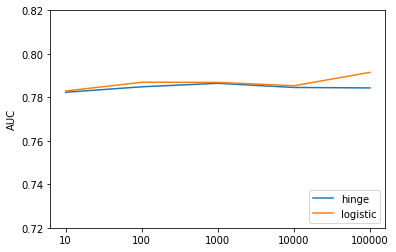

In [48]:
plt.plot(range(len(slices)),ROC_AUC_H-.005,label = 'hinge')
plt.plot(range(len(slices)),ROC_AUC_L-.005,label = 'logistic')
plt.ylabel('AUC')
plt.xticks(range(len(slices)),slices)
plt.ylim(0.72,0.82)
plt.legend(loc = 'lower right')
plt.show()